In [1]:
import pandas as pd 
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt 

=================================================================================================================
# Lecture Notes: Ensemble Learning


##### D.Vidotto, Data Mining: JBI030 2019/2020


=================================================================================================================

So far, we have considered regressors and classifiers individually. **Ensembles**, on the other hand, consider the predictions provided by combinations of estimators, with the goal of decreasing the *variance* of low bias models, or decreasing the bias of low variance models. By combining the predictions of each of such base algorithms (called *base learners*),  ensembles constitute a very powerful predictive method (although not easily interpretable); an extra advantage is that they do not require too much tuning to work well. In this notebook we will mostly explore two ensemble methods that have been proven effective when applied to several datasets: *Bagging* (which includes *Random Forests*) and *Boosting*.

In this notebook, the following topics will be discussed:

1. Introduction
1. Bagging
   * Motivation
   * Bagging
   * Random Forests
   * Hyperparameters
   * Out-Of-Bag Performance
1. Boosting 
   * Motivation
   * Gradient Boosting
   * AdaBoost
   * Boosting: Hyperparameters
1. Interpretation and Feature Importance
1. Other Remarks 
1. Examples in Python 
   * Bagging
   * Random Forests
   * Gradient Boosting
   * AdaBoost
1. Other Ensembles
   * Voting 
   * Stacking
   * XGBoost
1. Example on the Heart Data 

## 1. Introduction 
Consider the case in which you have to make a critical decision. In this case, rather than trust the opinion of just one advisor, you could try to collect opinions from several experts, so to obtain different viewpoints. In a democratic setting, then, you would combine the opinions of these experts either with consensus, or with a majority vote. 

This is exactly the idea behind ensembles: they combine the predictions of several "experts" (base learners, which can be classifiers or regressors depending on the problem) whose individual predictions are not that reliable. When these predictions are combined together, however, ensemble models can reach incredibly good performance. 

The main goal of ensembles is rather simple to understand: they either use a combination of high-variance, low-bias learners to reduce variance (bagging), or they use a combination of high-bias, low-variance learners to reduce bias (boosting). 
Let's start with bagging.

## 2. Bagging
### 2.1 Motivation
Remember the bias/variance decomposition: 

$$ \mathbb{E}[(y^* - \hat{f}(x^*))^2] = \left(Bias[\hat{f}(x^*)]\right)^2 + Var[\hat{f}(x^*)] + Var(e^*)$$

where 

$$ Var[\hat{f}(x^*)] = \mathbb{E}\left\{\left(\hat{f}(x^*)-\mathbb{E}[\hat{f}(x^*)]\right)^2\right\} $$

and $\mathbb{E}[\hat{f}(x^*)]$ represents the expected prediction of an estimator $f$ across all possible samples in a population. 

Suppose that $f$ is a low-bias, high-variance estimator (regressor or classifier). If we got the chance to get the prediction of $f$ closer to its average, we could reduce its variance while keeping the bias term untouched. Ideally, we would like to achieve $\hat{f}(x^*) \rightarrow \mathbb{E}[\hat{f}(x^*)]$. 

In probability theory, the [law of large numbers](https://en.wikipedia.org/wiki/Law_of_large_numbers) states that the average results of an experiment repeated for a large enough number of times approaches its expected value: 

$$\frac{1}{B}\sum_{i=1}^{B}y_b \rightarrow \mathbb{E}(y)\ as\ B \rightarrow +\infty$$

Imagine the following experiment. We toss four perfectly balanced coins (50-50 chances of Heads and Tails) ten times each, and we take note of the number of times (proportion) that we obtain "Head". The following histograms report the results of the experiments: 

<br>
<img src="./img/ensembles/coin_trials.png" width="400"/>
<br> 

As you can see, the proportion of Heads is on average around 0.5 across different trials, but it can vary from experiment to experiment. Now, suppose that for each coin we repeat the same experiment 5000 times, and each time we calculate the "average proportion" obtained across the various trials. The following figure reports the results. 

<br>
<img src="./img/ensembles/coin_bootstrap.png" width="600"/>
<br>

Now, the average proportions keep being rather unstable for the first 10000 trials, but as the experiment proceeds, the all tend to converge to the expected value of 0.5, decreasing in this way the variability of the estimate: this is the law of large numbers in action.   

When dealing with a dataset, imagine that the dataset you are analysing is like an experiment with one coin, and that the calculated proportion is the prediction returned by an estimator. If we had the chance to replicate the dataset for a large enough number of times, then we could exploit the law of large number to reduce the variance of the estimator. This is the purpose of *bagging*. 


### 2.2 Bagging 
**Bootstrap**. Bagging stands for *Bootstrap Aggregating*, and it exploits the [bootstrap](https://en.wikipedia.org/wiki/Bootstrapping_(statistics)) technique to replicate a dataset. In statistics, bootstrap works as follows:  

Having a training dataset $\mathcal{D} = \{(\mathbf{x}_i, y_i), i=1,...,n\}$: 
1. replicate the dataset $B$ times (where $B$ can be arbitrarily large) by resampling $n$ times its rows (the units) uniformly at random **with replacement**
1. for each replication $\mathcal{D}_b\ (b=1,...,B)$ calculate the estimate of interest (for example, a regression coefficient or a sample mean)
1. combine the results of point (2) (for example, by averaging them) to obtain the final estimate

In practice, bootstrapping is an alternative way to obtain the estimates of a population, taking into account the sampling uncertainty (actually bootstrap is used also for other purposes, but this is beyond the scope of this lecture). In particular, in step (1) it is very important that the resampling of the units is obtained with replacement: this will allow to obtain different datasets at each replication $b$ with high probability. For example, if our original dataset is composed of the following units ($n=3$):  

$$ \mathcal{D} = [a, b, c], $$ 

then two possible bootstrap replications may look as follows: 

$$  \mathcal{D}_1 = [b, b, a] $$
$$  \mathcal{D}_2 = [a, c, a] $$


In practice, each unit has a positive probability to be included in each replicate, but it has also positive probability of being excluded. This increases the probaibility of obtaining different samples every time (the probability increases with increasing $n$). Potentially, we could obtain a dataset where only one unit is present and replicated $n$ times (although this might happen only with probability $\left(\frac{1}{n}\right)^n$). Furthermore, it is possible to prove (asymptotically) that the probability for a unit to be part of a bootstrap sample $b$ is roughly 60%, while it has 40% chances not to belong to it. Last, it is important that data in $\mathcal{D}$ are i.i.d. (independent, identically distributed) in order for the bootstrap to work properly. Independence (as well as sampling with replacement) ensures that the bootstrap samples are independent with each other. The identical distribution assumption ensures that the bootstrap replications come from the same data generating mechanism, which gives it the chance to provide a good (approximate) representation of the distribution of the estimate of interest calculated in points (2) and (3). 

**Bootstrap Aggregating**. Bagging uses the technique of bootstrap to improve the variance of an estimator. In practice, it works in the same way as statisticians use bootstrap to obtain statistical estimates, but with one difference: at each replicate, instead of the estimate of a parameter we are interested in the predictions of a base regressor/classifier (base learner), which has large variance. Evantually, its predictions are combined. The following figures gives a schematic representation of how bagging works: 


<br>
<img src="./img/ensembles/bagging.png" width="500"/>
<br>


In bagging, each bootstrap sample is also called *bag*. The key that makes this method so effective is the bootstrap: by setting a sufficiently large $B$, bagging exploits the law of large numbers to reduce variance. As a consequence, the combined estimate $\hat{y}_{bagging}$ has lower variance than each single prediction $\hat{y}_b$ for $b=1,...,B$. This, of course, under the assumption that each prediction $\hat{y}_b$ comes from a high-variance and low-bias model (for instance, a tree growth to the maximum possible depth). 

How are the bootstrap predictions of the base learners $\hat{y}_{b}$ combined? In regression (where $\hat{y} = f(\mathbf{x})$) by simple average over all bootstrap samples: 

$$\hat{y}_{i, bagging} = \frac{1}{B}\sum_{b=1}^{B} \hat{y}_{i,b} = \frac{1}{B}\sum_{b=1}^{B} f_b(\mathbf{x}_i)$$

In classification, the prediction of the class occurs by **majority vote**: we predict the class that occurs the most over all replications. Alternatively, we can obtain the probability of a class $c$ by averaging the predicted probabilities at each replication: 

$$\hat{p}_{bagging}\left({y_i=c}\right) = \frac{1}{B}\sum_{b=1}^{B} \hat{p}_{b}({y_i=c)}.$$

The class with the largest final $p$ will become the predicted class of unit $i$. This method is also called **soft voting** (and it is the one implemented, for example, by scikit-learn). 


Bagging can be used with any high-variance base learner  (for example, unregularized linear models, knn with $k=1$, and so on). However, in general trees are ideal candidates for ensemble methods (this is why ensembles are usually presented and implemented with trees). In the case of bagging, trees can capture high-order interaction structures in the data, and when grown sufficiently deep, have low bias. Moreover, deep trees produce rather noisy predictions, and so they can greatly benefit from the type of averaging performed with bagging.    

Importantly, the predictions generated by bagging are i.d. (identically distributed), but not independent. Because the datasets generated at each bootstrap replications share some of the same data, the relationships found for example by a tree will hardly differ too much from replicate to replicate (for example, the first split detected by a tree in most of the bootstrap samples might occur at very similar points of the same feature); the resulting trees will then be likely correlated. As [we know from results in probability and statistics](https://en.wikipedia.org/wiki/Variance#Sum_of_correlated_variables), the variance of the sum of correlated variables is larger than the one of uncorrelated variables, which makes the gain in variance of a bagging estimator still significant, but not as strong as if we had independent samples (as the law of large numbers assume). 

### 2.3 Random Forests
Random Forests is a popular method that uses bagging in combination with trees as base learners. The trees are usually grown until maximum possible depth (i.e., all leaves are pure) in order to obtain low-bias predictions for each bootstrap training sample. 

However, Random Forests have a substantial difference with Bagging: each split of a tree is evaluated on a different (randomly drawn) subsample (of size $m<p$) of the features, rather than the whole set of features of the dataset. This increases the probability of obtaining more diverse trees at each bootstrap replication, and therefore it reduces the correlations among trees. In turn, this guarantees with high probability a further gain in variance w.r.t. the normal bagging. Random Forest is a very powerful prediction tool that have been proven effective in a wide range of applications. 

We can summarize the Random Forest algorithm as follows: 
1. Draw $B$ bootstrap replications of size $n$ of the training dataset
1. For $b=1,...,B$: 
   * grow a tree $T_b$ with bootstrap replication $b$, by repeating the following steps until all leaves are pure or some other criterion is met:
         1. select m features at random among the p in the dataset
         2. pick the best feature/split-point among the m
         3. split the node 
1. output the forest $T = \{T_1,...,T_B\}$
    
As seen for bagging, predictions are then obtained either with averaging (regression) or with majority/soft vote (classification) of the final forest. In this figure, we can see an example of classifications obtained for each tree of a Random Forest, along with the final forest. To simplify visualization, we use a small forest with $B=7$ trees.

<br>
<img src="./img/ensembles/random_forest.png" width="800"/>
<br>

In this example (where the features predict the classes by means of non-linear relationships), each single trees struggle to find a good decision boundary, and it overfits the dataset. However, when results are averaged the final forest can drastically reduce the mistakes made by each single tree, and it ends up with a decision boundary that will probably generalize well to new test data. Notice, furthermore, that the decision boundaries detected by random forest are not axis-aligned anymore as a result of the averaging. Of course, the number of trees used in this example (7) is very low for the typical forest size; increasing this number will further improve results (as the decrease in variance will be more clear-cut). 

### 2.4 Hyperparameters
A nice feature of Bagging and Random Forest methods is that they have a very small number of hyperparameters, and these hyperparameters can be easily tuned. 

* Number of replications $B$: in general, there is no limit to such number. It can be set arbitrarily large without deteriorating model performance. This is because there will always be (in general) a decrease in variance of the estimator, while bias won't grow. Thus, unless your dataset is very noisy, Bagging methods will rarely overfit. You can notice, however, that the improvement in the generalization performance of the model won't be that evident anymore after a certain number of replications, as the decrease in variance becomes less significant for too large $B$. Usually, values between 100/200 and 10000 should work well in several occasions (but you can increase it further if you want). Keep also in mind that the time taken by the computations increases with $B$

* Number of features to use for the split $m$: this is a parameter specific of Random Forest (Bagging can be seen as a Random Forest with $p=m$). While you can decide to tune such parameter, empirical studies have shown that setting $m = \sqrt{p}$ (rounded to the largest integer) works well in practice in classification problems, while $m = p/3$ can be used as a starting point in regression. 

* Other hyperparameters that are learner-specific. It is important to remark that the base learners in Bagging use the same hyperparameters for all bootstrap replications. Keep also in mind that, if you want bagging to be effective, the base learner must be set in such a way that they lead to low-bias, and high-variance predictions. 

In this figure, we can see an example of training and test set performance for a classification Random Forest with different values of $B$ and $m$. The dataset is composed of $p=200$ features and $n=199$ observations. 

<br>
<img src="./img/ensembles/rf_hyperparameters.png" width="600"/>
<br>

Notice how the number of features selected affects the performance of the Forest, and how the test error tends to "stabilize" after some bootstrap iterations. Last, it should also be noticed how the training error goes to 0 quickly as we proceed with the estimation of the forest. For this dataset, it looks like that the best combination is using $\sqrt{p}$ features at each split, and stopping the boosting procedure at about 250 iterations. 


### 2.5 Out-Of-Bag Performance
Bagging methodologies offer a further advantage w.r.t. other algorithms: they can automatically provide an estimate of the generalization performance without requiring a validation set. The reason is very simple: as mentioned above, at each replication only about 60% (asymptotically, 63.2%) of the units are included in the bootstrap sample. This means that, at each Bagging iteration, we have about 40% of units that are not included in the sample used to train the base learner. We can therefore calculate a performance metrics on the excluded units (called *out-of-bag* units) to evaluate how each single learner is performing. The average of this metrics across all bootstrap iterations and out-of-bag data points provide a final estimate of the generalization performance of bagging. 

Formally, let's define for a generic unit $i$ in the orignal dataset its 'out-of-bag' prediction to be: 

$$ \hat{y}_{i,oob} = \frac{1}{B_{-i}} \sum_{b\ \in\ \mathcal{D}_{-i}} f_b(\mathbf{x}^*_i)   $$

where $\mathcal{D}_{-i}$ is the set of all bootstrapped datasets in which unit $i$ is not included, $B_{-i}$ is the number of these datasets, and we use the notation $f_b(\mathbf{x}^*_i)$ to stress that $i$ is treated as a test unit in replication $b$. The out-of-bag value of a metric $\mathcal{M}$ (which can be a squared loss, a classification error, accuracy, $f_1$ score, and so on) then is: 

$$\mathcal{M}_{oob} = \frac{1}{n}\sum_{i=1}^{n} \mathcal{M}(\hat{y}_{i,oob}, y_i)$$

which in practice is the average OOB metric across all units in the original dataset. 

The oob performance is a valid estimate of the test performance, as it is computed on units that are not used to train the base learners. In the next figure, we compare oob accuracy with the accuracy of a validation set for a Random Forest in a classification context, using a number of trees between 10 and 500 and $m=\sqrt{p}$.  


<br>
<img src="./img/ensembles/rf_oob.png" width="600"/>
<br>

As the figure shows, the OOB and Validation accuracy convey similar information. 



## 3. Boosting
### 3.1 Motivation 
Boosting is a technique devised with the opposite purpose of Bagging: instead of using overfitting estimators and try to decrease their bias, boosting seeks to sequentially estimate a series of poor (high-bias) classifiers using at each iteration the residuals of the ensemble at step $t$. The goal is to reduce bias at each iteration. 

Boosting has some analogy and differences with Bagging: 
* like Bagging, it combines the results of several base learners ("experts") to perform a prediction
* unlike Bagging, boosting uses low-variance, high-bias base learners (called **weak learners** in this context)
* similar to Bagging, Decision Trees are default learners also for Boosting
* while bagging can be seen as a *parallel* algorithm, where each learner is trained independently of the others, boosting can be seen as a *sequential* algorithm, where the training at some iteration $t$ depends on the results obtained at iteration $t-1$

In Boosting, the definition of *weak learner* is a learner that can do just slightly better than random guessing. Similar to Bagging, typical choices for such learners are Decision Trees. Because the goal here is to improve the bias of the estimators, Boosting uses shallow -rather than deep- trees. The typical *maximum depth* of a tree in Boosting is between 1 (in which case it is called a Decision Stump) and 8. Of course, the use of other regressors and classifiers is possible, as long as it is a weak learner (high-bias estimator). In this notebook, we will present boosting using Decision Trees.  

The typical Boosting estimator can be represented as: 

$$\hat{y}_{boosting} = \sum_{t=1}^{T} \alpha f_t(\mathbf{x})$$

where $T$ is the number of boosting iterations (it is the analogous of $B$ in bagging), and $\alpha$ (usually set between 0 and 1) is the learning rate (it can be interpreted like the learning rate of Gradient Descent). To highlight the predictions made by the ensemble after $t'$ iterations, we will alternatively use this notation: 

$$ F_{t'}(\mathbf{x}) = \sum_{t=1}^{t'} \alpha f_t(\mathbf{x})$$

While in the next sub-sections we are going to discuss some specific ways to do boosting, here we shall see a general idea of the algorithm. Roughly, boosting works as follows: 

1. At iteration $t=0$, predict a constant value $F_0$ (for example 0 or the sample mean): predict $F_0$ for all units;
1. For $t=1,...,T$: 
    1. For all the training data points, compute the residuals $r_i$ between $y_i$ and the predictions of the model $F_{t-1}$
    1. Train a weak learner $f_t$ using $r_i$ as target variable
    1. Set $F_t = F_{t-1} + \alpha f_t$
    
The goal of boosting is to reduce the errors ($r_i$'s) at each iteration with the weak learners, to get the ensemble closer and closer to the true observed targets. The speed of such learning is controlled by the step size $\alpha$.    
       
Here we shall see an example in a regression case (but boosting can be implemented also for classification problems), using shallow trees (max depth = 2) as weak learners. In the left column you can see the tree-specific predictions on the residuals at each iteration, while on the right you can see the predictions made by the ensemble. In the first row there is only one tree, so the predictions of the ensemble correspond to the ones of the tree. To keep things simple, we only show an example of the first three iterations of Boosting and $\alpha=1$. 



<br>
<img src="./img/ensembles/boosting_intro.png" width="900"/>
<br>

Because the weak learners of Boosting have high bias, they do not learn the observed target in just one step, but they get slowly close to it at each iteration. In this way, Boosting can focus on specific aspects of the dataset (the iteration-specific residuals) one step at a time.  

From the previous picture, we can also see how at each step boosting actually is solving two optimization problems: one, to optimize the global function $F$, and one to optimize the weak learners $f$.  


### 3.2 Gradient Boosting
Gradient Boosting is an implementation of Boosting that works both in Classification and in Regression. Boosting can be seen as a Gradient Descent optimization problem, hence the name of the algorithm. In particular, we can see Boosting as GD in function (rather than parameter) space; therefore, we try to optimize a loss function directly w.r.t. the function of the estimator, rather than w.r.t. some parameter. 

Besides a learning rate and a weak learner, Boosting methods also need a loss function $L(y_i, F(\mathbf{x}_i))$ to optimize. This, as usual, can be the Residuals Sum of Squares (or MSE) in regression and the cross-entropy in classification. The algorithm then proceeds as introduced previously. The residuals for the $i$-th unit are computed as the *negative gradient of the loss function w.r.t. the ensemble function F*:

$$ r_i = -\left[\frac{\partial L(y_i, F(\mathbf{x}_i))}{\partial F(\mathbf{x}_i)}\right]$$

and these are called *pseudo-residuals*. This calls for a bit of explanation. Optimizing w.r.t. a function means finding the direction towards which the function should be moved in order to get closer to the global minimum. Loosely speaking, the derivative w.r.t. $F$ is telling us *how much the loss is steep at that specific point*, and therefore how much we should move $F$ to get it closer to the optimum (for this reason it is called pseudo-residual). The negative sign is due to the fact the we want to minimize the loss, and therefore we want to move downward towards this minimum. 

Although the formula for $r_i$ looks difficult, it is not actually! Let's take the squared loss as an example: 


$$ \frac{\partial L(y_i, F(\mathbf{x}_i))}{\partial F(\mathbf{x}_i)} = 
 \frac{\partial \frac{1}{2}(y_i - F(\mathbf{x}_i))^2}{\partial F(\mathbf{x}_i)} = 
F(\mathbf{x}_i) - y_i
$$
and in this case you can see that the pseudo-residuals are similar to the typical residuals of a regression problem. 

In a multiclass classification case, the vector of labels is one-hot encoded so that $y_{i,c} \in \{0,1\}$ and it is equal to 1 only when $y_i=c$. We would execute a Boosting algorithm for each class. For the $c$-th class, then, the predicted probability is calculated through the softmax function:  

$$ p_{i,c}(\mathbf{x}_i) = \frac{e^{F_c(\mathbf{x}_i)}}{\sum_k e^{F_k(\mathbf{x}_i)}}$$

In this case the negative derivative of the cross-entropy can be easily shown to be:

$$\frac{\partial L(y_i, F(\mathbf{x}_i))}{\partial F(\mathbf{x}_i)} = \mathcal{I}(y_{i,c}=1) - p_{i,c}$$

In the binary case, you can just train one ensemble and use the binary cross-entropy already encountered with Neural Networks. You can find more details about these and other loss functions in Table 10.2 at page 360 of [The Elements of Statistical Learning](https://web.stanford.edu/~hastie/Papers/ESLII.pdf). 

Now that we have undestood how the gradients of the loss function $L$ are calculated, we can examine the algorithm for Gradient Boosting: 

1. At iteration $t=0$, set for example $F_0 = 0$ for all units;
1. For $t=1,...,T$: 
    1. for $i=1,...,n$ compute the pseudo-residuals <br><br>$ r_i = -\left[\frac{\partial L(y_i, F_{t-1}(\mathbf{x}_i))}{\partial F_{t-1}(\mathbf{x}_i)}\right]$<br><br>
    1. Train a weak learner (such as a tree) $f_t$ using ($\mathbf{x}_i, r_i$) for $i=1,...,n$ as training dataset such that the loss $L(r_i, f_t)$ is minimized
    1. Set $F_t = F_{t-1} + \alpha f_t$
1. Output $F_T$

Importantly, because the $r_i$'s of step 2A are continuous values, the weak learner of step 2B must necessarily be a regression algorithm (e.g., a regression tree). 
    
### 3.3 AdaBoost  
AdaBoost is the first boosting algorithm ever appeared in the literature. AdaBoost is actually a specific instance of Gradient Boosting, which represent the more general version, although its algorithm was discovered later. 

AdaBoost is tailored specifically for binary classification problems, where $y_i \in \{-1,1\}$ - and therefore its weak learner must also be a binary classifier (whose output is $f_t \in \{-1,1\}$). The main differences with the boosting algorithms we have ancountered so far are: 

* at each iteration, AdABoost assigns a weight $w_i$ to each unit; the weak learners are trained giving different weights to each unit
* the step size $\alpha$ of AdaBoost is updated at each step with a specific analytic formula; the idea is that AdaBoost can recognize automatically which weak learners are more important, and gives them a larger weight. This is the feature of AdaBoost that gives it its name (AdaBoost stands for "Adaptive Boosting"). The ensemble of AdaBoost can then be written as <br> $$F_t(\mathbf{x}) = F_{t-1}(\mathbf{x}) + \alpha_t f_t(\mathbf{x})$$<br>
* AdaBoost uses a new loss function: the *exponential loss* defined as: <br>$$L(y_i,F(\mathbf{x}_i)) = e^{-y_iF(\mathbf{x}_i)}$$<br> We will see what this loss looks like shortly. 

It turns out that these three elements are the main reasons of the success of AdaBoost: 

* at each step, larger weights are given to those units miss-classified during the previous iteration (and smaller weights to the correctly classified ones), which allows the weak learners of AdaBoost to focus more on the errors (possibly until all units are correctly classified) 
* the automatic update of the step size allows AdAboost to automatically recognize which weak learner should be given more importance when performing the predictions, and it allows it to converge faster by gradually reducing the step sizes as the algorithm gets close to the optimal solution   
* the exponential loss (compared with other losses encountered so far) looks like as follows: <br> <br>
<img src="./img/ensembles/exponential_loss.png" width="400"/> <br> As you can see, the exponential loss gives much more weight to larger errors than any other loss; this means that, during training, the exponential loss will cause the classifier to adjust its predictions more towards the miss-classified unit, so that it can get close to 0 faster.  


The following figure shows how the iterations of AdaBoost are run: 

<img src="./img/ensembles/adaboost.png" width="300"/> 


In the figure, $sign(z)$ is the function equal to -1 if $z<0$, and to 1 otherwise, and it helps to assign the final class to the units. The final ensemble is composed of the sum of the results of all the weak classifiers (remember that each $f_t \in \{-1,1\}$). 

The next plots show the first three iterations of AdaBoost. Here, a Decision Stump (decision tree with max depth = 1) is used as weak learner. The point size corresponds to the weights given at each iteration by the algorithm (during the first iteration, all units are given the same weight). 

<img src="./img/ensembles/adaboost_iter.png" width="700"/> 

At each iteration, the algorithm detects the miss-classified points and give them more weights for the next iteration; points that are given more weights are more likely to be correctly classified at the next step. The final ensemble, which is a weighted sum of the predictions at each step (where the weights are given by the step size $\alpha_t$), produces an accurate classifier. Notice also how the step size decreases at each iteration. 

Here is the AdaBoost algorithm: 

1. initialize the weights $w_i=\frac{1}{n}$ for all the training units $i=1,...,n$ 
1. For t=1,...,T: 
    1. fit a weak classifier $f_t(\mathbf{x})$ with the training data, giving weights $w_i$ to each observation $i$ 
    1. compute the weighted mis-classification error <br>$$err_t = \frac{\sum_{i:y_i\neq f_t(\mathbf{x}_i)}^n w_i}{\sum_{i=1}^n w_i}$$<br>
    1. update the step size <br>$$\alpha_t=log\frac{1-err_t}{err_t}$$<br>
    1. update the weigths for $i=1,...,n$:  <br>$$w_i \leftarrow w_i \cdot e^{\alpha_t \cdot \mathcal{I}(y_i\neq f_t(\mathbf{x}_i))} $$<br>
1. Output $F(\mathbf{x}) = sign\left(\sum_{t=1}^T \alpha_t f_t(\mathbf{x})\right)$


* in the initial step, all units are given the same weight $1/n$; subsequently, units that are miss-classified are given larger weights, proportional to the miss-classification rate of classifier $f_t$
* the step-size is updated incrementally, and it is given a value proportional to the log-odds ratio of the weighted accuracy of $f_t$; the idea is to give more weight (larger step size) to those model that perform better (that have higher accuracy)


### 3.4 Boosting: Hyperparameters 
Similar to Bagging, Boosting also does not have too many hyperparameters to tune. However, unlike Bagging, they can have a stronger influence on the final performance of the algorithm: 

* number of iterations $T$: if $T$ is too small, the final ensemble might not be accurate enough, while if $T$ is too large, it might be over-fitting (although it has been observed that boosting starts to overfit after a veeery large number of iterations). A possible solution can be given by *early stopping* (already discussed with Neural Networks), which requires setting aside a small validation set to assess when the algorithm stops learning. 

* The learning rate is a very delicate parameter in Boosting, and it interacts strongly with the number of iterations. A low value of the learning rate slows down learning, but it has been shown to provide very accurate results (decreasing the likelihood of overfitting). In AdaBoost, a fixed learning rate can be mulitplied by the step size of each iteration. The learning rate is also called *shrinkage* parameter

* Hyperparameters related of the weak learners. The weak learners can also be tuned, but it must be kept in mind that Boosting is effective only with high-bias (and low-variance) learners. When trees are used, usually what is tuned is the max depth of the tree. In general, values of max depth between 1 and 8 work well in practice (but a larger max depth can be beneficial sometimes). Some authors see a max depth equal to 6 as a good default choice.

The following figure shows the performance of a boosting algorithm with varying learning rate and number of iterations: 

<img src="./img/ensembles/gb_hyperparameters.png" width="800"/>

The Boosted trees with lowest learning rate (0.001), in this case, takes more iterations to "kick in", but its test set accuracy overperforms the ones of Boosting with larger learning rates after a bunch of iterations. If early stopping was set with learning rate 0.001, it would have stopped computations probably after 100 iterations. Keep in mind that Boosting here was run in a small (two features) dataset, and probably in other applications a larger number of iterations should be used. 

Let's now compare the performance of Boosting with varying maximum tree depth and number of iterations. This is done on the same two-features data: 

<img src="./img/ensembles/gb_hyperparameters_2.png" width="800"/>

We see that also tree depth strongly affects the results of boosting (in this case, using weak decision trees with max. depth equal to 5 reaches a test set accuracy close to 90% between 30 and 70 iterations). 


## 4. Interpretation and Feature Importance
A disadvantage of ensemble methods is that it is very hard (if not impossible) to interpret them, since they use the results of several models (whose results might even be in conflict with each other). However, there is a nice way to detect univariate feature importance for ensemble methods. 

As you may recall from the Decision Trees lecture, we can calculate feature importance on a tree by summing the loss in impurity (e.g., loss in Gini/entropy index in classsification, or loss in MSE in regression) across all the splits of a tree caused by each specific feature. Ensembles can estimate the importance of a feature by simply taking the average feature importances obtained across each single tree of their algorithm. Such averages are then normalized so that we can interpret the output as the *relative importance* of the feature. For example: 

<img src="./img/ensembles/feat_importance.png" width="500"/>

In the figure above, for example, we may say that 'feature 5' was the most important feature, determining (on average) about 17.5% of the gain in purity of the whole ensemble, followed by 'feature_17' with about 12% contribution. 

This can be a way to give a simple interpretation to the results of an ensemble. Despite the simplicity of this method, there are some caveats: 

* this method only accounts for univariate feature importances, disregarding possible interactions between features
* this method does not give any information about the *direction* of the relationships between the feature and the target. For example, we don't know if 'feature_5' above predicts a specific target when its value is increased or decreased


## 5. Other Remarks
* When trees are used as Base learners, ensembles require a minimum amount of preprocessing steps, for the same reasons seen when discussing Decision Trees. For example, continuous features need not be standardized
* In Bagging, since the base learners are trained independently of each other, we have an [Embarissingly Parallel](https://en.wikipedia.org/wiki/Embarrassingly_parallel) problem that can easily exploits multi-core computations 
* Boosting, unlike Bagging, cannot be parallelized, as its next iteration depend on the results of the previous one. However, when trees are used as learners, an iteration of Boosting can be faster than an iteration of Bagging, as it uses shallow trees which are faster to compute 
* It is possible to "bag" Boosting, by subsampling (without replacement) a fraction of the training data points from the dataset at each iteration. This has the advantage of speeding up computations, as well as to offer an "out-of-bag" measure of performance 
* Learn more about Ensembles in the [scikit-learn documentation](https://scikit-learn.org/stable/modules/ensemble.html)


## 6. Examples in Python 
In this section, we are going to see examples of implementations of Bagging and Boosting in scikit-learn. In particular, we will see the following models:

* Bagging in Regression using a linear model as base learner
* Random Forests in classification
* Gradient Boosting in Regression using a Regression Tree
* AdaBoost with classification Trees

We will see examples with the Boston housing dataset for the regression cases (already encountered in the Neural Networks lecture), and with the moons data in classification. 

### 6.1 Bagging - Regression Case
*Bagging* can be implemented with two functions in scikit-learn: 

* [BaggingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingRegressor.html) in regression
* [BaggingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) in classification

The two functions require as input a `base_estimator`, which of course must be a regressor for regression, and a classifier for classifications. The reamining hyperparameters are the same for the two functions: 
* `n_estimators` the number of bootstrap replications 
* `max_samples` the number of units to resample at each iteration (the default value of 1 means 100% of the units, and it is usually a good choice)
* `oob_score` if an out-of-bag score ($R^2$ in regression, Accuracy in classification) is desired

Let's see Bagging in action. We first load the data: 

In [2]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
bunch_data = load_boston()
features = bunch_data.feature_names
X_boston, y_boston = bunch_data.data, bunch_data.target
X_boston_train, X_boston_test, y_boston_train, y_boston_test = train_test_split(X_boston, y_boston, 
                                                                                test_size=0.1, random_state=10)

We now run the algorithm for increasing number of bootstrap replications, and will require the 'oob-score'. For reproducibility, we also set the `random_state`. 

In [3]:
from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import LinearRegression

# Try every 50 number of bootstrap replications between 20 and 1000 
n_iter = np.arange(20, 1000, 50)
# Here we will store the oob scores: 
oob_scores = np.zeros(len(n_iter))

i = 0
for b in n_iter: 
    print("n_bags = ", b)
    bag_reg = BaggingRegressor(base_estimator= LinearRegression(), 
                              n_estimators = b, oob_score=True, n_jobs=-1, random_state=1)
    bag_reg.fit(X_boston_train, y_boston_train)
    oob_scores[i] = bag_reg.oob_score_ 
    i += 1

n_bags =  20
n_bags =  70
n_bags =  120
n_bags =  170
n_bags =  220
n_bags =  270
n_bags =  320
n_bags =  370
n_bags =  420
n_bags =  470
n_bags =  520
n_bags =  570
n_bags =  620
n_bags =  670
n_bags =  720
n_bags =  770
n_bags =  820
n_bags =  870
n_bags =  920
n_bags =  970


Let's now plot the results. 

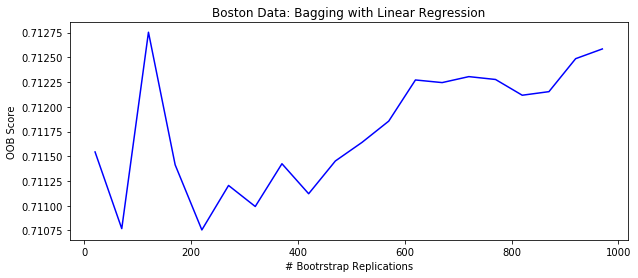

In [4]:
plt.figure(figsize=(10,4))
plt.plot(n_iter, oob_scores, "b-", label="OOB Scores")
plt.xlabel("# Bootrstrap Replications")
plt.ylabel("OOB Score")
plt.title("Boston Data: Bagging with Linear Regression")
plt.show()

It seems like the linear model could slightly (probably not significantly) benefit from bagging. Let's now check the $R^2$ score on the test data: 

In [5]:
best_B = n_iter[np.argmax(oob_scores)]
best_bag = BaggingRegressor(base_estimator= LinearRegression(), 
                           n_estimators = best_B, n_jobs=-1, random_state=1)
best_bag.fit(X_boston_train, y_boston_train)

BaggingRegressor(base_estimator=LinearRegression(copy_X=True,
                                                 fit_intercept=True,
                                                 n_jobs=None, normalize=False),
                 bootstrap=True, bootstrap_features=False, max_features=1.0,
                 max_samples=1.0, n_estimators=120, n_jobs=-1, oob_score=False,
                 random_state=1, verbose=0, warm_start=False)

In [6]:
best_bag.score(X_boston_test, y_boston_test)

0.7159400580882553

The reason why linear models do not benefit from Bagging too much is that they are usually rather stable (low-variance) models (unless multicollinearity is present in the dataset). As an exercise, try to bag a high-variance neural network and compare the results. This can be, for example, a NN with several neurons and layers. (Note: the computations might take a while)

### 6.2 RandomForest - Classification Case 
*RandomForest* can also be implemented with two functions in scikit-learn: 

* [RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) in regression
* [BaggingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) in classification

The two functions take as input similar arguments: 
* `n_estimators` the number of trees in the forest
* `criterion` to perform the splits of the trees; this can be `gini` or `entropy` in classification, or `mse` in regression
* `oob_score` same as for the Bagging functions 
* `max_features` the number of features $m$ to draw when evaluating each split 
* other tree-specific hyperparameters (the default lets the tree grow until all leaves are pure, which works fine in most cases) 

Let's load the "moons" dataset to see an implementation of RandomForestClassifier. 

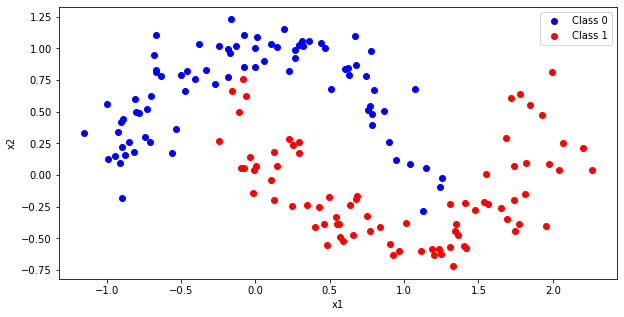

In [7]:
# Import Data 
data = pd.read_csv("./data/ensembles/moons.csv")
X_moons = data.iloc[:,:2].to_numpy()
y_moons = data["y"].to_numpy()
X_moons_train, X_moons_test, y_moons_train, y_moons_test = train_test_split(X_moons, y_moons, 
                                                                            stratify=y_moons, test_size=0.2, 
                                                                            random_state=1)
plt.figure(figsize=(10,5))
plt.plot(X_moons_train[y_moons_train==0,0], X_moons_train[y_moons_train==0,1], "bo", label="Class 0")
plt.plot(X_moons_train[y_moons_train==1,0], X_moons_train[y_moons_train==1,1], "ro", label="Class 1")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.show()

We are going to see an example of RandomForest in classification (circles data) with $m=\sqrt{p}$ and $B=500$ estimators (unlike what done in Bagging, we won't vary the number of iterations but if you wish to do that the commands are similar - the same holds also for the Boosting methods we will see in the next subsections). Trees are grown until full depth, and an 'oob' score will be requested. 

In [8]:
from sklearn.ensemble import RandomForestClassifier 
rfc = RandomForestClassifier(n_estimators=500, criterion="gini", max_features="sqrt", oob_score=True, random_state=2)
rfc.fit(X_moons_train, y_moons_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=True, random_state=2, verbose=0,
                       warm_start=False)

Let's check the OOB and test-set scores: 

In [9]:
rfc.oob_score_

0.9625

In [10]:
rfc.score(X_moons_test, y_moons_test)

0.95

The decision boundary: 

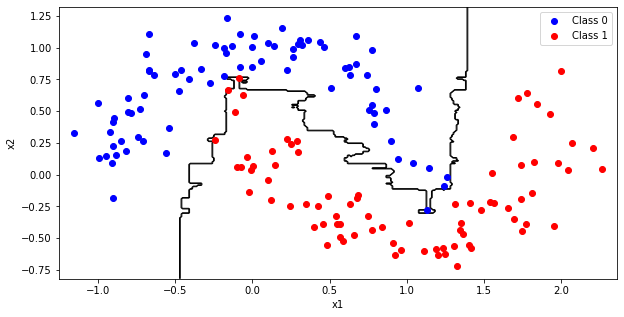

In [11]:
x1_r = np.arange(X_moons_train[:,0].min()-0.1, X_moons_train[:,0].max()+0.1, 0.01)
x2_r = np.arange(X_moons_train[:,1].min()-0.1, X_moons_train[:,1].max()+0.1, 0.01)
xx1, xx2 = np.meshgrid(x1_r, x2_r)
z = rfc.predict(np.c_[xx1.ravel(), xx2.ravel()]).reshape(xx1.shape)

plt.figure(figsize=(10,5))
plt.contour(xx1, xx2, z, levels=1, colors='k', alpha=1., linewidths=1, linestyles='-')
plt.plot(X_moons_train[y_moons_train==0,0], X_moons_train[y_moons_train==0,1], "bo", label="Class 0")
plt.plot(X_moons_train[y_moons_train==1,0], X_moons_train[y_moons_train==1,1], "ro", label="Class 1")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.show()

Last, we can retrieve feature importance (it is trivial in this 2-features case): 

In [12]:
rfc.feature_importances_

array([0.42665452, 0.57334548])

This is (roughly) telling us that $X_2$ gives about 60% of the total contribution to the prediction of the class.

### 6.3 Gradient Boosting - Regression Case 
Also Gradient Boosting can be implemented in two ways: 
* [GradientBoostingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html) in regression 
* [GradientBoostingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html) in classification

The arguments taken by these functions are: 
* `loss`, which can be `ls` (least squares) in regression and `deviance` in classification (note: Deviance in this context is the equivalent name that statisticians give to the cross-entropy) 
* `learning_rate` for the ensemble learning rate 
* `n_estimators` for the number of iterations 
* `criterion` for the splits of the trees, for example `mse` 
* other hyperparameters of the tree, among which `max_depth` is the most commonly tuned 

We now apply Gradient Boosting to the Boston housing data, using $T=500$ iterations, learning rate equal to 0.1, least square loss and trees max depth of 1. 

In [13]:
from sklearn.ensemble import GradientBoostingRegressor
gdb = GradientBoostingRegressor(loss='ls', learning_rate=1e-1, n_estimators=500, max_depth=1, random_state=1)
gdb.fit(X_boston_train, y_boston_train)
gdb.score(X_boston_test, y_boston_test)

0.8661697267660574

This means that Boosting can explain about 87% of the variability in the target variable (House prices). Gradient Boosting also allows retrieving feature importances: 

In [14]:
np.c_[features, gdb.feature_importances_]

array([['CRIM', '0.032817051073207856'],
       ['ZN', '0.00024761740177345413'],
       ['INDUS', '0.0020214016197257797'],
       ['CHAS', '0.005142553469723449'],
       ['NOX', '0.0413556124440193'],
       ['RM', '0.3355774397756961'],
       ['AGE', '0.0014635483510282734'],
       ['DIS', '0.046633337619809576'],
       ['RAD', '0.0031222489427412147'],
       ['TAX', '0.00845392387654319'],
       ['PTRATIO', '0.023283434189300914'],
       ['B', '0.008145122466813698'],
       ['LSTAT', '0.4917367087696173']], dtype='<U32')

It seems like that LSTAT (% lower status of population) and RM (avg. # of rooms per dwelling) are the most important predictor for house prices in the Boston dataset. Let's try to plot them against the target, to see if we can learn more about their (univariate) relationship with house prices: 

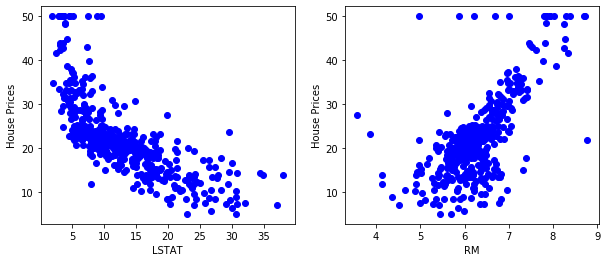

In [15]:
plt.figure(figsize=(10,4))
plt.subplot(1,2, 1)
plt.plot(X_boston_train[:,12],y_boston_train, "bo")
plt.xlabel("LSTAT")
plt.ylabel("House Prices")
plt.subplot(1,2, 2)
plt.plot(X_boston_train[:,5],y_boston_train, "bo")
plt.xlabel("RM")
plt.ylabel("House Prices")
plt.show()

Indeed, there seems to be strong dependencies between the features LSTAT (apparently a negative linear one, with some curvature) and RM (roughly a relationship of linear type). Gradient Boosting was able to detect them.

As an exercise, try to vary learning rate and number of iterations, to see whether you can furhter improve the performance of Gradient Boosting. 

### 6.2 AdaBoost
[AdaBoostClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html) takes the following main inputs: 
* `base_estimator` (with the default `None`, it uses a Decision Tree with `max_depth=1`) 
* `n_estimators` number of AdaBoost iterations
* `learning_rate`, which multiplies the step size at each iteration (in general the default of 1 works fine)

We come back to the "moons" data and show how AdaBoost works. We are going to use a Decision Tree with max depth equal to 1, 50 iterations, and learning rate equal to 1. 

In [16]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1), 
                        n_estimators=50, learning_rate=1., random_state=1)
ada.fit(X_moons_train, y_moons_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=1,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

The accuracy on the test set: 

In [17]:
ada.score(X_moons_test, y_moons_test)

0.925

Therefore, AdaBoost performs a bit worse than RandomForest in this case (but remember that the number of iterations, as well as the learning rate, can be tuned). The found decision boundary is: 

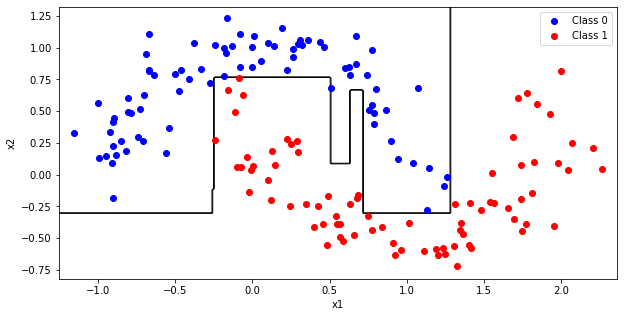

In [18]:
x1_r = np.arange(X_moons_train[:,0].min()-0.1, X_moons_train[:,0].max()+0.1, 0.01)
x2_r = np.arange(X_moons_train[:,1].min()-0.1, X_moons_train[:,1].max()+0.1, 0.01)
xx1, xx2 = np.meshgrid(x1_r, x2_r)
z = ada.predict(np.c_[xx1.ravel(), xx2.ravel()]).reshape(xx1.shape)

plt.figure(figsize=(10,5))
plt.contour(xx1, xx2, z, levels=1, colors='k', alpha=1., linewidths=1, linestyles='-')
plt.plot(X_moons_train[y_moons_train==0,0], X_moons_train[y_moons_train==0,1], "bo", label="Class 0")
plt.plot(X_moons_train[y_moons_train==1,0], X_moons_train[y_moons_train==1,1], "ro", label="Class 1")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.show()

Notice how the decision boundaries are less "noisy" than those of RandomForest; this is due to the fact that we are using shallow trees as base learners. Last, we can check feature importance according to AdaBoost:

In [19]:
ada.feature_importances_

array([0.64, 0.36])

In this case, the biggest contribution is given by feature $X_1$. 

**Note**: scikit-learn allows also implementing a regression version of AdaBoost, [AdaBoostRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html). The functioning is similar to AdaBoost for classification.  

## 7. Other Ensembles 

* **Voting methods**. The functioning of Voting is very simple: you can choose a number of base learners (these can be very different from each other: a Decision Tree, KNN, a Neural Network, and so on), and the final prediction is given by the average prediction of each single estimator. If weights are provided for each estimator, the final prediction is a weighted average (this means that the prediction of each estimator has a different influence). Learn more about [VotingClassifier](https://scikit-learn.org/stable/modules/ensemble.html#voting-classifier) and [VotingRegressor](https://scikit-learn.org/stable/modules/ensemble.html#voting-regressor) in the scikit-learn documentation.   

* **Stacking**. Stacking works in a hierarchical way: on a first level, several estimators (base learners) are trained on the training dataset. On a second level, another estimator (called meta-regressor, or meta-classifier) is trained by taking as input the predictions at the previous level. 

<img src="./img/ensembles/stacking.png" width="500"/>

The base estimators can be very diverse from each other: one can be a Decision Tree, another one a linear model, another one a Neural Network, and so on. Stacking can be implemented in scikit-learn. Found out more [in the documentation](https://scikit-learn.org/stable/modules/ensemble.html#stacked-generalization).

* **XGBoost**. XGBoost (short for extreme Gradient Boosting) is a novel version of Gradient Boosting, optimized with specific data structures that allow much faster computations than Gradient Boosting. XGBoost, furthermore, allows for more control on the regularization of the trees. This combinations allow XGBoost to provide scalable, portable, and accurate results. XGBoost has gained a lot of popularity in the last years (for example, it has won several Kaggle competitions). XGBoost is not implemented in scikit-learn, but it has its own [Python package](https://xgboost.readthedocs.io/en/latest/python/python_intro.html). The library is also available in languages other than Python. You can learn more about XGBoost in its [documentation page](https://xgboost.readthedocs.io/en/latest/get_started.html).


## 8. Example on the Heart Data 
Here, we are going to implement ensembles on the Heart Dataset. We are going to compare two ensemble methods: 
* RandomForest
* AdaBoost

We will use Randomized Search to perform model search and tuning. For these techniques we search across the following parameters: 
* number of iterations (both for AdaBoost and RandomForest), between 50, 100, 500, and 1000
* learning rate (AdaBoost), which will be given a reciprocal distribution (between 1e-4 and 0.99)
* number of features to perform the splits (RandomForest), varied between 2, 3, and $\sqrt{p}$

As usual, we first load the data. 

In [20]:
data_train = pd.read_csv("./data/heart_data/heart_train_processed.csv")
data_test = pd.read_csv("./data/heart_data/heart_test_processed.csv")
X_train = data_train.drop("y", axis=1)
X_test = data_test.drop("y", axis=1)
y_train = data_train["y"]
y_test = data_test["y"]

We now prepare the grid and run 10-fold-cross-validation. Since we are comparing different classifiers, we will create a Pipeline first. 

In [21]:
from sklearn.pipeline import Pipeline
from scipy.stats import reciprocal    # Reciprocal distribution in scipy.stats
from sklearn.model_selection import RandomizedSearchCV

pipe = Pipeline([('classifier', RandomForestClassifier())])
n_trees = [50, 100, 500, 1000]
# Create space of candidate learning algorithms and their hyperparameters
search_space = [{'classifier': [AdaBoostClassifier(random_state=1)],
                 'classifier__learning_rate': reciprocal(1e-4, 9.9e-1),
                 'classifier__n_estimators': n_trees},
                {'classifier': [RandomForestClassifier(random_state=1)],
                 'classifier__n_estimators': n_trees,
                 'classifier__max_features': [2, 3, "sqrt"]}]

The grid is ready. Let's run RandomizedSearchCV. For the search, we are going to perform 50 iterations.

In [22]:
rnd_search_cv = RandomizedSearchCV(pipe, search_space, n_iter=50, cv=10, n_jobs=-1, iid=False, 
                                  random_state=1, verbose=2)
rnd_search_cv.fit(X_train, y_train)
print("Randomized Search: Done")

Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   37.3s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  4.6min


Randomized Search: Done


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  5.7min finished
c:\users\u1253415\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


The best classifier was AdaBoost: 

In [23]:
rnd_search_cv.best_estimator_

Pipeline(memory=None,
         steps=[('classifier',
                 AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
                                    learning_rate=0.1120987699404295,
                                    n_estimators=50, random_state=1))],
         verbose=False)

with the following hyperparameters: 

In [24]:
rnd_search_cv.best_params_

{'classifier': AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
                    learning_rate=0.1120987699404295, n_estimators=50,
                    random_state=1),
 'classifier__learning_rate': 0.1120987699404295,
 'classifier__n_estimators': 50}

This produced the best CV accuracy: 

In [25]:
rnd_search_cv.best_score_

0.8391666666666666

As usual, we can store the results in a dataframe (notice that the best CV scores are obtained with AdaBoost)...

In [26]:
results = pd.DataFrame(rnd_search_cv.cv_results_).sort_values(["mean_test_score"], 
                                                             ascending=False)
results.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier,param_classifier__max_features,param_classifier__n_estimators,param_classifier__learning_rate,params,split0_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
46,0.115172,0.008906,0.012396,1.199564e-03,"AdaBoostClassifier(algorithm='SAMME.R', base_e...",NaN,50,0.112099,{'classifier': AdaBoostClassifier(algorithm='S...,0.88,...,0.916667,0.833333,0.875000,0.833333,0.833333,0.875000,0.75,0.839167,0.058120,1
29,3.108968,0.887660,0.361109,3.187389e-01,"AdaBoostClassifier(algorithm='SAMME.R', base_e...",NaN,1000,0.00920761,{'classifier': AdaBoostClassifier(algorithm='S...,0.92,...,0.916667,0.791667,0.833333,0.833333,0.791667,0.833333,0.75,0.838667,0.057134,2
20,2.453786,0.124846,0.230742,3.881489e-02,"AdaBoostClassifier(algorithm='SAMME.R', base_e...",NaN,1000,0.00444995,{'classifier': AdaBoostClassifier(algorithm='S...,0.88,...,0.916667,0.750000,0.875000,0.875000,0.833333,0.833333,0.75,0.830833,0.064032,3
47,0.109173,0.005380,0.012797,1.599789e-03,"AdaBoostClassifier(algorithm='SAMME.R', base_e...",NaN,50,0.101828,{'classifier': AdaBoostClassifier(algorithm='S...,0.88,...,0.916667,0.791667,0.875000,0.833333,0.833333,0.833333,0.75,0.830833,0.058358,3
41,0.111543,0.008906,0.009383,1.609833e-03,"RandomForestClassifier(bootstrap=True, ccp_alp...",3,50,NaN,{'classifier': RandomForestClassifier(bootstra...,0.92,...,0.833333,0.791667,0.916667,0.833333,0.791667,0.916667,0.75,0.830667,0.066776,5
38,0.119570,0.004542,0.009198,1.832788e-03,"RandomForestClassifier(bootstrap=True, ccp_alp...",3,50,NaN,{'classifier': RandomForestClassifier(bootstra...,0.92,...,0.833333,0.791667,0.916667,0.833333,0.791667,0.916667,0.75,0.830667,0.066776,5
45,0.113572,0.007417,0.008397,1.199834e-03,"RandomForestClassifier(bootstrap=True, ccp_alp...",3,50,NaN,{'classifier': RandomForestClassifier(bootstra...,0.92,...,0.833333,0.791667,0.916667,0.833333,0.791667,0.916667,0.75,0.830667,0.066776,5
13,0.115571,0.011514,0.007998,7.156530e-07,"RandomForestClassifier(bootstrap=True, ccp_alp...",3,50,NaN,{'classifier': RandomForestClassifier(bootstra...,0.92,...,0.833333,0.791667,0.916667,0.833333,0.791667,0.916667,0.75,0.830667,0.066776,5
14,0.113573,0.005711,0.012396,2.153908e-03,"AdaBoostClassifier(algorithm='SAMME.R', base_e...",NaN,50,0.205574,{'classifier': AdaBoostClassifier(algorithm='S...,0.88,...,0.916667,0.791667,0.833333,0.750000,0.791667,0.833333,0.75,0.826333,0.058351,9
44,0.232231,0.007725,0.017595,2.652374e-03,"RandomForestClassifier(bootstrap=True, ccp_alp...",2,100,NaN,{'classifier': RandomForestClassifier(bootstra...,0.92,...,0.833333,0.791667,0.916667,0.833333,0.791667,0.916667,0.75,0.822833,0.093217,10


...and we can plot them (here we see the best 20 models): 

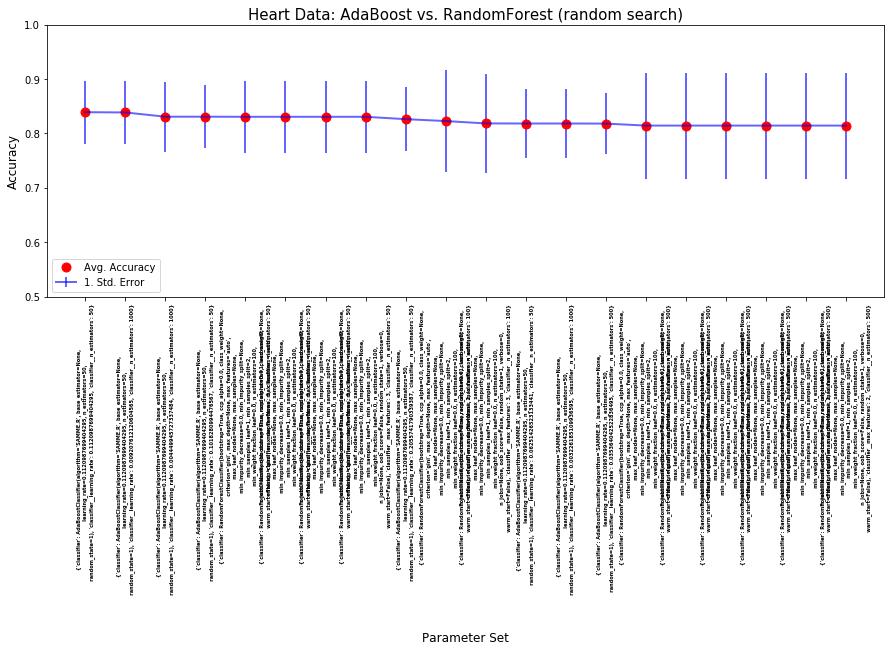

In [27]:
# Plot accuracy of 20 best models
best = 20
fig = plt.figure(figsize=(15,5))
ax = plt.subplot(1,1,1)
ax.tick_params(axis='x', rotation=90)
plt.errorbar(range(best), results.iloc[0:best]["mean_test_score"], 
             yerr=results.iloc[0:best]["std_test_score"], c="blue", label="1. Std. Error", alpha=0.6,
            linewidth=2)
plt.plot(range(best), results.iloc[0:best]["mean_test_score"], 
         "ro", label="Avg. Accuracy", markersize=9)
plt.xticks(range(best), labels=results.iloc[0:best]["params"], 
          fontweight='bold', fontsize=5)
plt.xlabel('Parameter Set', fontsize=12)
plt.title('Heart Data: AdaBoost vs. RandomForest (random search)', fontsize=15)
plt.ylabel("Accuracy",fontsize=12)
plt.legend(loc=3)
plt.ylim(0.5,1)
plt.show()

The first Random Forest classifier ranks fifth, and randomly selects $m=3$ features at each split; this forest is composed of 50 trees. The best CV accuracy for a RandomForest is 0.830, against 0.839 of the best AdaBoost model. 

Let's check the feature importance of the best AdaBoost model:  

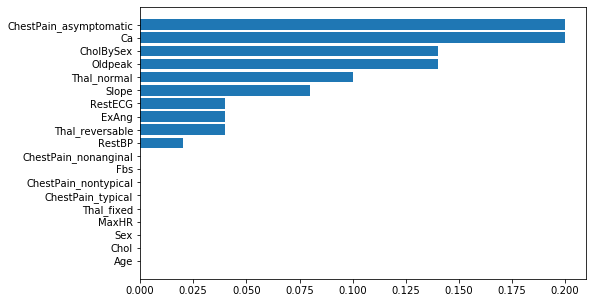

In [28]:
importances = rnd_search_cv.best_estimator_['classifier'].feature_importances_
ind_sort = np.argsort(importances)

plt.figure(figsize=(8,5))
plt.barh(np.arange(1, X_train.shape[1]+1, 1), importances[ind_sort])
plt.yticks(np.arange(1, X_train.shape[1]+1, 1), labels=X_train.columns[list(ind_sort)])
plt.show()

(Compare with feature importances observed in the Decision Trees notebook). Last, let's assess the accuracy on the test set of the best model (AdaBoost) found by RandomizedSearch: 

In [29]:
rnd_search_cv.score(X_test, y_test)

0.8360655737704918

This result is not so far from what we obtained with the linear models (Logistic Regression and LinearSVM); probably, by increasing the number of Randomized Search iterations and expanding the hyperparameter grid, we could find an even better ensemble. 

**Exercise**: try to re-run the experiment, adding Bagging with varying number of iterations (try to use KNN=1 and a Linear SVM with large value for $C$, or SVM with Polynomial Kernel with large $C$ and and large value of the degree $d$ as base learners), and Gradient Boosting with varying iterations, learning rates, and maximum depth of the decision trees. Tune the maximum depth also for AdaBoost. If you feel like, try also implementing stacking on this dataset (you can choose and tune the base learners). Increase the number of iterations of Randomized Search to search across a larger space. 